In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import robot_vlp.data_collection.experment_processing as ep
import robot_vlp.modeling.gen_cnc_vlp_model as vlp
import robot_vlp.data_collection.communication as c
import matplotlib.patches as patches
import pickle
import robot_vlp.modeling.EKF as ekf
import robot_vlp.stats.navigation_performance as nav

from robot_vlp.config import EXPERIMENT_DATA_DIR, VLP_MODELS_DIR, FIGURES_DIR, INTERIM_DATA_DIR


%load_ext autoreload
%autoreload 2


2026-02-10 11:27:01.815 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


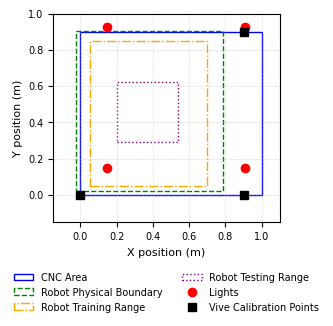

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

ONE_COL_WIDTH = 3.35
HIRES_DPI = 1200
SUPTITLE_FONT = 9
TITLE_FONT = 8
LABEL_FONT = 8
TICK_FONT = 7
LEGEND_FONT = 7


# --------------------------
# Config
# --------------------------



# --------------------------
# Helper: plot a bounded region by its corner points (outline only)
# --------------------------
def plot_capture_region(ax, exp, *, label, edge='k', linestyle='--', linewidth=1.0):
    if exp == 'trans_and_rotate':
        tar_pattern = np.array([
            [0.314, 0.4],
            [0.314, 0.622],
            [0.538, 0.622],
            [0.538, 0.4],
        ])
    elif exp == 'trans':
        tar_pattern = np.array([
            [0.202, 0.4],
            [0.202, 0.622],
            [0.426, 0.622],
            [0.426, 0.4],
        ])
    elif exp == 'rotate':
        tar_pattern = np.array([
            [0.37,  0.3345],
            [0.37,  0.5665],
            [0.594, 0.5665],
            [0.594, 0.3345],
        ])
    else:
        raise ValueError(f"Unknown exp: {exp}")

    poly = patches.Polygon(
        tar_pattern, closed=True,
        fill=False, edgecolor=edge,
        linewidth=linewidth, linestyle=linestyle,
        label=label
    )
    ax.add_patch(poly)

# --------------------------
# Define regions & points
# --------------------------
cnc_origin = (0, 0)
cnc_width = 1
cnc_height = 0.9

robot_x_min = -0.165 + 0.14
robot_x_max = 0.925 - 0.14
robot_y_min = -0.12 + 0.14
robot_y_max = 1.045 - 0.14

actual_x_min, actual_x_max = 0.05, 0.7
actual_y_min, actual_y_max = 0.05, 0.85

live_nav_x_min, live_nav_x_max = 0.2, 0.54
live_nav_y_min, live_nav_y_max = 0.29, 0.62

lights = [
    (0.145, 0.145),
    (0.145, 0.925),
    (0.905, 0.925),
    (0.905, 0.145)
]

vive_points = [
    (0.9, 0),
    (0, 0),
    (0.9, 0.9)
]

# --------------------------
# Create plot
# --------------------------
fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH, ONE_COL_WIDTH))

# CNC area
cnc_rect = patches.Rectangle(
    cnc_origin, cnc_width, cnc_height,
    linewidth=1.0, edgecolor='blue', facecolor='none',
    label='CNC Area'
)
ax.add_patch(cnc_rect)

# Robot accessible area
robot_rect = patches.Rectangle(
    (robot_x_min, robot_y_min),
    robot_x_max - robot_x_min,
    robot_y_max - robot_y_min,
    linewidth=1.0, edgecolor='green', facecolor='none',
    linestyle='--', label='Robot Physical Boundary'
)
ax.add_patch(robot_rect)

# Actual robot movement area
actual_robot_rect = patches.Rectangle(
    (actual_x_min, actual_y_min),
    actual_x_max - actual_x_min,
    actual_y_max - actual_y_min,
    linewidth=1.0, edgecolor='orange', facecolor='none',
    linestyle='-.', label='Robot Training Range'
)
ax.add_patch(actual_robot_rect)

# Live navigation range
live_nav_rect = patches.Rectangle(
    (live_nav_x_min, live_nav_y_min),
    live_nav_x_max - live_nav_x_min,
    live_nav_y_max - live_nav_y_min,
    linewidth=1.0, edgecolor='purple', facecolor='none',
    linestyle=':', label='Robot Testing Range'
)
ax.add_patch(live_nav_rect)

# Lights
for x, y in lights:
    ax.plot(x, y, 'ro', markersize=6)
light_legend = ax.plot([], [], 'ro', markersize=6, label='Lights')[0]

# Vive calibration points
for x, y in vive_points:
    ax.plot(x, y, 'ks', markersize=6)
vive_legend = ax.plot([], [], 'ks', markersize=6, label='Vive Calibration Points')[0]

# --------------------------
# Overlay target regions (outline only)
# --------------------------
# plot_capture_region(ax, 'trans',            label='Translation-only', edge='tab:orange')
# plot_capture_region(ax, 'rotate',           label='Rotation-only',    edge='tab:green')
# plot_capture_region(ax, 'trans_and_rotate', label='Combined', edge='tab:cyan')

# --------------------------
# Axes, legend, layout
# --------------------------
ax.set_aspect('equal')
ax.set_xlabel('X position (m)', fontsize=LABEL_FONT)
ax.set_ylabel('Y position (m)', fontsize=LABEL_FONT)
ax.tick_params(axis='both', labelsize=TICK_FONT)
ax.grid(True)

# Deduplicate legend entries
handles, labels = ax.get_legend_handles_labels()
seen = set()
dedup_handles, dedup_labels = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        dedup_handles.append(h)
        dedup_labels.append(l)
        seen.add(l)
ax.legend(dedup_handles, dedup_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False, fontsize=LEGEND_FONT)

plt.xlim(-0.15, 1.1)
plt.ylim(-0.15, 1.0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.28)
ax.grid(True, alpha=0.3)   # 30% opacity
ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.5)
# Show plot
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-where_things_are.png', dpi=HIRES_DPI)  # Save as PNG at 1200 DPI
plt.show()
plt.show()

## Vive driven robot

In [27]:
def run_ekf_on_df(df):

    err_stats = {
    'R_x': np.float64(0.0011877283113252916),
    'R_y': np.float64(0.001091556953648103),
    'R_theta': np.float64(0.04948532100320507),
    'Q_theta': np.float64(0.0002164107393016196),
    'Q_theta_no_turn': np.float64(4.006326132012649e-05),
    'Q_dist': np.float64(1.761140402328462e-06)
    }

    ekf_df = ekf.run_ekf(df.iloc[:].reset_index(drop = True),err_stats)

    ekf_pre_loc = ekf_df[['EKF_x', 'EKF_y']].values
    ekf_pre_rad  = ekf_df['EKF_heading_rad'].values 
    ekf_loc_errs = nav.calc_loc_err(ekf_pre_loc, df[['x_hist', 'y_hist']].values)
    ekf_ang_errs = ekf_pre_rad - df['heading_hist_rad'].values
    ekf_ang_errs = np.array([nav.normalize_angle_rad(ang) for ang in ekf_ang_errs])

    return ekf_ang_errs, ekf_loc_errs

In [28]:
vlp_model = vlp.load_vlp_models()['high_acc']
# df_lst = []
# for i in range(0,10):
#     path = EXPERIMENT_DATA_DIR/f'Robot/exp1_{i}.csv'
#     df_lst.append(ep.process_robot_exp_file(path, vlp_model))
# df = pd.concat(df_lst[:-1])

df_lst = []
for i in range(10):
    test_file = INTERIM_DATA_DIR / 'exp_vive_navigated_paths'/f'exp1_{i}_high_acc.csv'
    df = pd.read_csv(test_file)
    ekf_ang_errs, ekf_loc_errs = run_ekf_on_df(df)
    df['ekf_ang_errs'] = ekf_ang_errs
    df['ekf_loc_errs'] = ekf_loc_errs


    df_lst.append(df)
df = pd.concat(df_lst[:])

In [29]:
train_df = pd.concat(df_lst)
mean = ep.filter_outliers(train_df['vive_location_change'],threshold= 3).mean()
std = ep.filter_outliers(train_df['vive_location_change'],threshold= 3).std()
print(f"move forward distance mean (m): {mean}")
print(f"move forward std: {std}")

step_counts = 445
enc_per_cm =   step_counts / (mean*100)
print(f'encoder counts per cm : {enc_per_cm}')

# put this in experment_processing.py 
# put this in EKF.py



move forward distance mean (m): 0.11176414084021037
move forward std: 0.0014117726717661986
encoder counts per cm : 39.815990769008664


In [30]:
def remove_outliers(x, y, threshold=2):
    """Removes points where residuals are greater than threshold * std."""
    initial_fit = np.polyfit(x, y, deg=1)
    predicted_y = np.polyval(initial_fit, x)
    residuals = y - predicted_y
    std_resid = np.std(residuals)
    mask = np.abs(residuals) < threshold * std_resid
    return x[mask], y[mask]



df = pd.concat(df_.iloc[1:] for df_ in df_lst[:-1])
turn_df = df[df['encoder_heading_change'] !=0]
clockwise_turn_df = turn_df[(turn_df['encoder_heading_change_step']>0) & (turn_df['vive_heading_change'] > 0) ]
anticlockwise_turn_df = turn_df[(turn_df['encoder_heading_change_step']<0) & (turn_df['vive_heading_change'] < 0) ]

# Apply outlier removal before fitting
cw_x, cw_y = remove_outliers(clockwise_turn_df['encoder_heading_change_step'].values,
                              clockwise_turn_df['vive_heading_change'].values)

cw_coef = np.polyfit(cw_x, cw_y, deg=1)
cw_line = np.poly1d(cw_coef)

acw_x, acw_y = remove_outliers(anticlockwise_turn_df['encoder_heading_change_step'].values,
                               anticlockwise_turn_df['vive_heading_change'].values)

acw_coef = np.polyfit(acw_x, acw_y, deg=1)
acw_line = np.poly1d(acw_coef)


### Function to put into experiment_processing.py

acw_line, cw_line




(poly1d([ 0.18816057, -0.82087375]), poly1d([0.18951681, 1.00878798]))

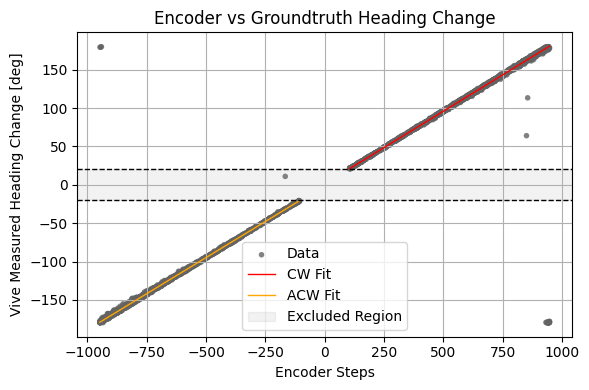

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def remove_outliers(x, y, threshold=2):
    """Removes points where residuals are greater than threshold * std."""
    initial_fit = np.polyfit(x, y, deg=1)
    predicted_y = np.polyval(initial_fit, x)
    residuals = y - predicted_y
    std_resid = np.std(residuals)
    mask = np.abs(residuals) < threshold * std_resid
    return x[mask], y[mask]

# Combine and filter data
df = pd.concat(df_.iloc[1:] for df_ in df_lst[:-1])
turn_df = df[df['encoder_heading_change'] != 0]

# Separate clockwise and anticlockwise turns
clockwise_turn_df = turn_df[(turn_df['encoder_heading_change_step'] > 20) & (turn_df['vive_heading_change'] > 0)]
anticlockwise_turn_df = turn_df[(turn_df['encoder_heading_change_step'] < -20) & (turn_df['vive_heading_change'] < 0)]

# Outlier removal and line fitting
cw_x, cw_y = remove_outliers(clockwise_turn_df['encoder_heading_change_step'].values,
                              clockwise_turn_df['vive_heading_change'].values)
cw_line = np.poly1d(np.polyfit(cw_x, cw_y, deg=1))

acw_x, acw_y = remove_outliers(anticlockwise_turn_df['encoder_heading_change_step'].values,
                               anticlockwise_turn_df['vive_heading_change'].values)
acw_line = np.poly1d(np.polyfit(acw_x, acw_y, deg=1))

# Plot
plt.figure(figsize=(6, 4))

# Raw data
plt.scatter(turn_df['encoder_heading_change_step'], turn_df['vive_heading_change'],
            label='Data', alpha=0.8, s=16, edgecolors='none', c='#636363')

# Fitted lines — plot only in their respective ranges
cw_x_vals = np.linspace(cw_x.min(), cw_x.max(), 100)
acw_x_vals = np.linspace(acw_x.min(), acw_x.max(), 100)

plt.plot(cw_x_vals, cw_line(cw_x_vals), color='red', linewidth=1, label='CW Fit')
plt.plot(acw_x_vals, acw_line(acw_x_vals), color='orange', linewidth=1, label='ACW Fit')

# Highlight the gap
plt.axhspan(-20, 20, color='grey', alpha=0.1, label='Excluded Region')
plt.axhline(-20, linestyle='--', color='black', linewidth=1)
plt.axhline(20, linestyle='--', color='black', linewidth=1)

# Labels and styling
plt.xlabel('Encoder Steps')
plt.ylabel('Vive Measured Heading Change [deg]')
plt.title('Encoder vs Groundtruth Heading Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_encoder_vs_groundtruth_fits.png')
plt.show()


In [32]:
# Total points before any filtering
total_points = len(turn_df)

# Points passing threshold filter
after_threshold = len(included_df)

# Points included in fit after outlier removal
after_outlier = len(cw_x) + len(acw_x)

# --- Compute percentages ---
excluded_threshold = total_points - after_threshold
excluded_outliers = after_threshold - after_outlier
excluded_total = total_points - after_outlier

print(f"Excluded by threshold: {excluded_threshold} / {total_points} = {100 * excluded_threshold / total_points:.2f}%")
print(f"Excluded as outliers: {excluded_outliers} / {total_points} = {100 * excluded_outliers / total_points:.2f}%")
print(f"Total excluded: {excluded_total} / {total_points} = {100 * excluded_total / total_points:.2f}%")



NameError: name 'included_df' is not defined

In [ ]:
%matplotlib inline

### Generated navigation points plot

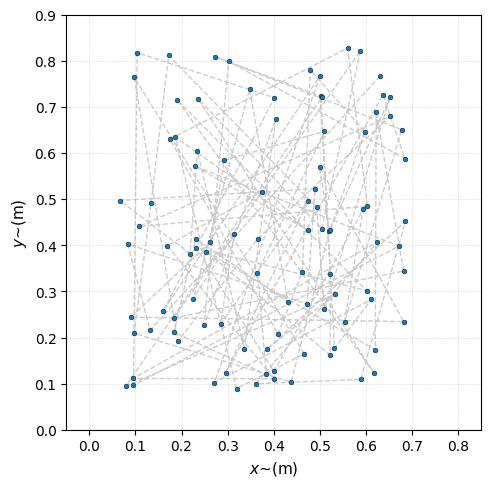

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_points(num_points, x_range, y_range, min_distance):
    x_lower, x_upper = x_range
    y_lower, y_upper = y_range
    all_targets = []

    x = np.random.uniform(x_lower, x_upper)
    y = np.random.uniform(y_lower, y_upper)
    all_targets.append([x, y])

    while len(all_targets) < num_points:
        x = np.random.uniform(x_lower, x_upper)
        y = np.random.uniform(y_lower, y_upper)
        last_x, last_y = all_targets[-1]
        distance = np.sqrt((x - last_x)**2 + (y - last_y)**2)
        if distance >= min_distance:
            all_targets.append([x, y])

    return np.array(all_targets)

# Parameters
x_range = (0.05, 0.7)
y_range = (0.05, 0.85)
num_points = 500
min_distance = 0.1
np.random.seed(3)  # exp1_1
all_targets = generate_random_points(num_points, x_range, y_range, min_distance)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))

# Plot dashed path (neutral color, low alpha)
ax.plot(all_targets[2:100, 0], all_targets[2:100, 1],
        linestyle='--',
        linewidth=1.0,
        color='gray',
        alpha=0.4,
        zorder=1)

# Overlay high-contrast target points
ax.scatter(all_targets[2:100, 0], all_targets[2:100, 1],
           color='tab:blue',
           s=12,  # size of dots
           edgecolors='black',
           linewidth=0.3,
           zorder=2,
           label='Target points')

# Axis and labels
ax.set_aspect('equal')
ax.set_xlim(-0.05, 0.85)
ax.set_ylim(0, 0.9)
ax.set_xlabel(r'$x$~(m)', fontsize=11)
ax.set_ylabel(r'$y$~(m)', fontsize=11)

# Grid and ticks
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

# Layout and save
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_points.png', dpi=300)
plt.show()


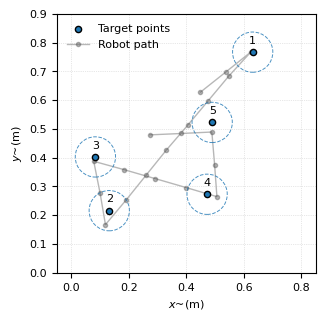

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH, ONE_COL_WIDTH))

# IEEE-style blue for target points
target_color = '#1f77b4'  # soft blue
circle_color = '#1f77b4'
path_color = '#4D4D4D'    # dark gray

# Plot target points
ax.scatter(all_targets[2:7, 0], all_targets[2:7, 1],
           color=target_color,
           edgecolors='black',
           s=20,
           zorder=3,
           label='Target points')

# Draw circles around each target
for x, y in zip(all_targets[2:7, 0], all_targets[2:7, 1]):
    circle = patches.Circle((x, y), radius=0.07,
                            fill=False, edgecolor=circle_color,
                            linewidth=0.7, linestyle='--',
                            alpha=0.8, zorder=2)
    ax.add_patch(circle)

# Add target point indices
for i, (x, y) in enumerate(zip(all_targets[2:7, 0], all_targets[2:7, 1]), start=1):
    ax.annotate(str(i), (x, y),
                textcoords="offset points",
                xytext=(0, 6),
                ha='center', fontsize=LABEL_FONT, zorder=4)

# Plot robot path in dark gray with larger marker size
ax.plot(df_lst[0]['x_hist'].iloc[10:30],
        df_lst[0]['y_hist'].iloc[10:30],
        color=path_color,
        alpha=0.4,
        marker='.',
        markersize=6,     # increased size
        linewidth=1,
        label='Robot path',
        zorder=1)

# Axes and layout
ax.set_aspect('equal')
ax.set_xlim(-0.05, 0.85)
ax.set_ylim(0, 0.9)
ax.set_xlabel(r'$x$~(m)', fontsize=LABEL_FONT)
ax.set_ylabel(r'$y$~(m)', fontsize=LABEL_FONT)
ax.tick_params(axis='both', which='major', labelsize=TICK_FONT)
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

# Legend
ax.legend(frameon=False, fontsize=LEGEND_FONT, loc='upper left')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_points_exa.png', dpi=HIRES_DPI)
plt.show()


### Stats for step distnace

In [ ]:
[len(df) for df in df_lst]

NameError: name 'df_lst' is not defined

In [ ]:
df = pd.concat(df_lst)

In [ ]:
len(df)

12832

In [ ]:
move_df = df[df['encoder_heading_change'] ==0]
turn_df = df[df['encoder_heading_change'] !=0]

In [ ]:
len(move_df), len(turn_df)

(9327, 3859)

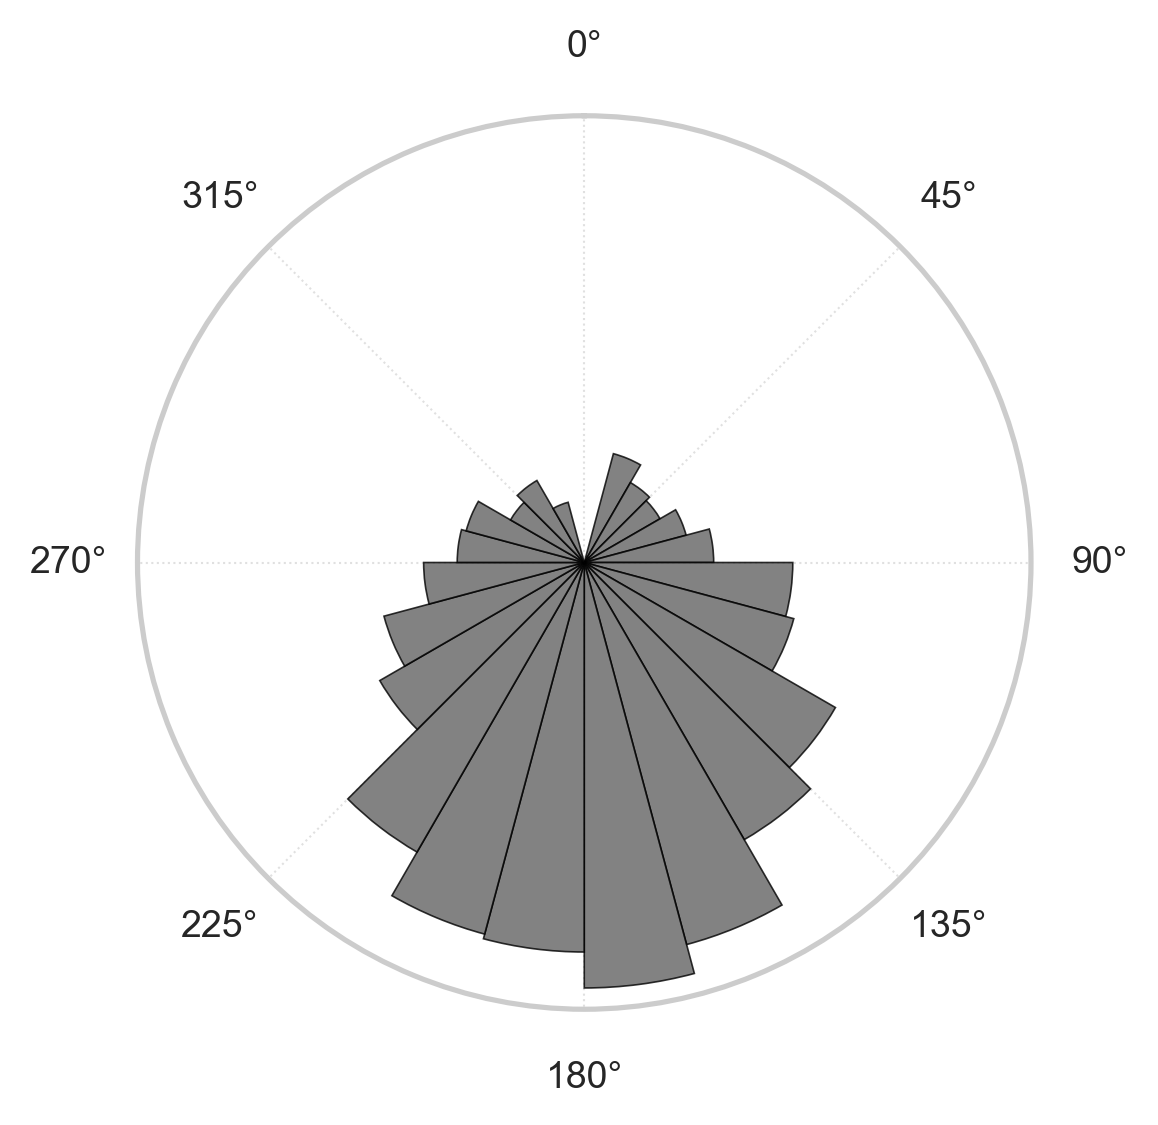

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert degrees to radians and wrap to [0, 2π]
theta_deg = turn_df['encoder_heading_change'].values
theta_rad = np.mod(np.deg2rad(theta_deg), 2 * np.pi)

# Define bins over full circle
num_bins = 24
bins = np.linspace(0, 2 * np.pi, num_bins + 1)
counts, bin_edges = np.histogram(theta_rad, bins=bins, density=True)  # normalized
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_width = 2 * np.pi / num_bins

# Create polar plot
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, polar=True)

# Plot normalized bars
bars = ax.bar(bin_centers, counts,
              width=bar_width,
              bottom=0.0,
              color="#636363",
              edgecolor='black',
              linewidth=0.4,
              alpha=0.8,
              zorder=2)

# Polar plot formatting
ax.set_theta_zero_location('N')      # 0° at top
ax.set_theta_direction(-1)           # Clockwise direction
ax.set_rticks([])                    # Hide radial ticks
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

# Degree labels around the circle
angle_degrees = [0, 45, 90, 135, 180, 225, 270, 315]
ax.set_thetagrids(angle_degrees,
                  labels=[f"{a}°" for a in angle_degrees],
                  fontsize=9)

# Save plot
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_turn_dist.png', dpi=300)
plt.show()


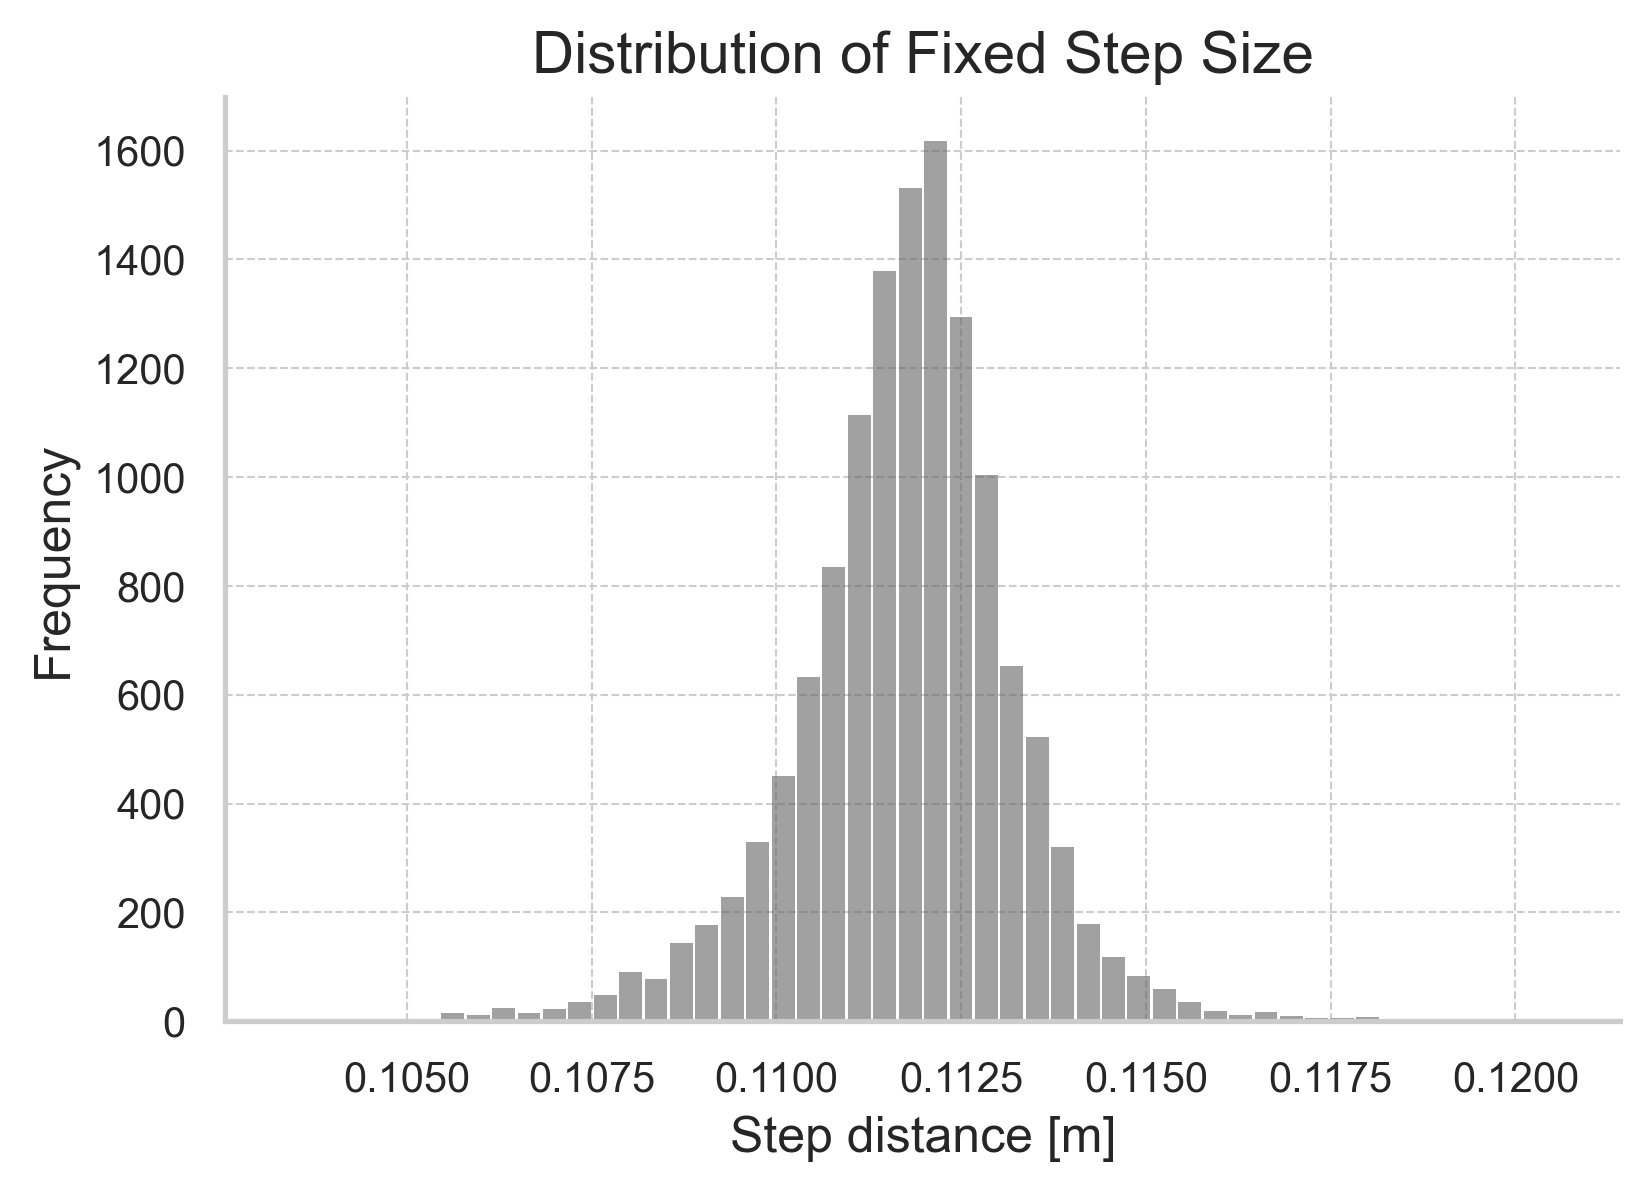

In [ ]:
# Compute custom bin edges for controlled rwidth
num_bins = 50
filtered = ep.filter_outliers(df['vive_location_change'], threshold=5)
bin_edges = np.linspace(filtered.min(), filtered.max(), num_bins + 1)

plt.figure(figsize=(6, 4))
plt.hist(filtered, bins=bin_edges, color="#636363", edgecolor='none', rwidth=0.9, alpha = 0.6)

plt.xlabel("Step distance [m]")
plt.ylabel("Frequency")
plt.title("Distribution of Fixed Step Size")
sns.despine()
plt.grid(True, linestyle='--', linewidth=0.5)

plt.savefig(FIGURES_DIR / 'methodology-robot_nav_step_err.png')
plt.show()


### Deriving rotation error

In [ ]:

move_df = df[df['encoder_heading_change_step'] == 0].iloc[1:-1]
turn_df = df[df['encoder_heading_change_step'] != 0].iloc[1:-1]
turn_df['enc_per_deg'] = (turn_df['encoder_heading_change_step']/turn_df['vive_heading_change'])
turn_df = turn_df[turn_df['enc_per_deg'] > 0 ]  # remove 'overturned'

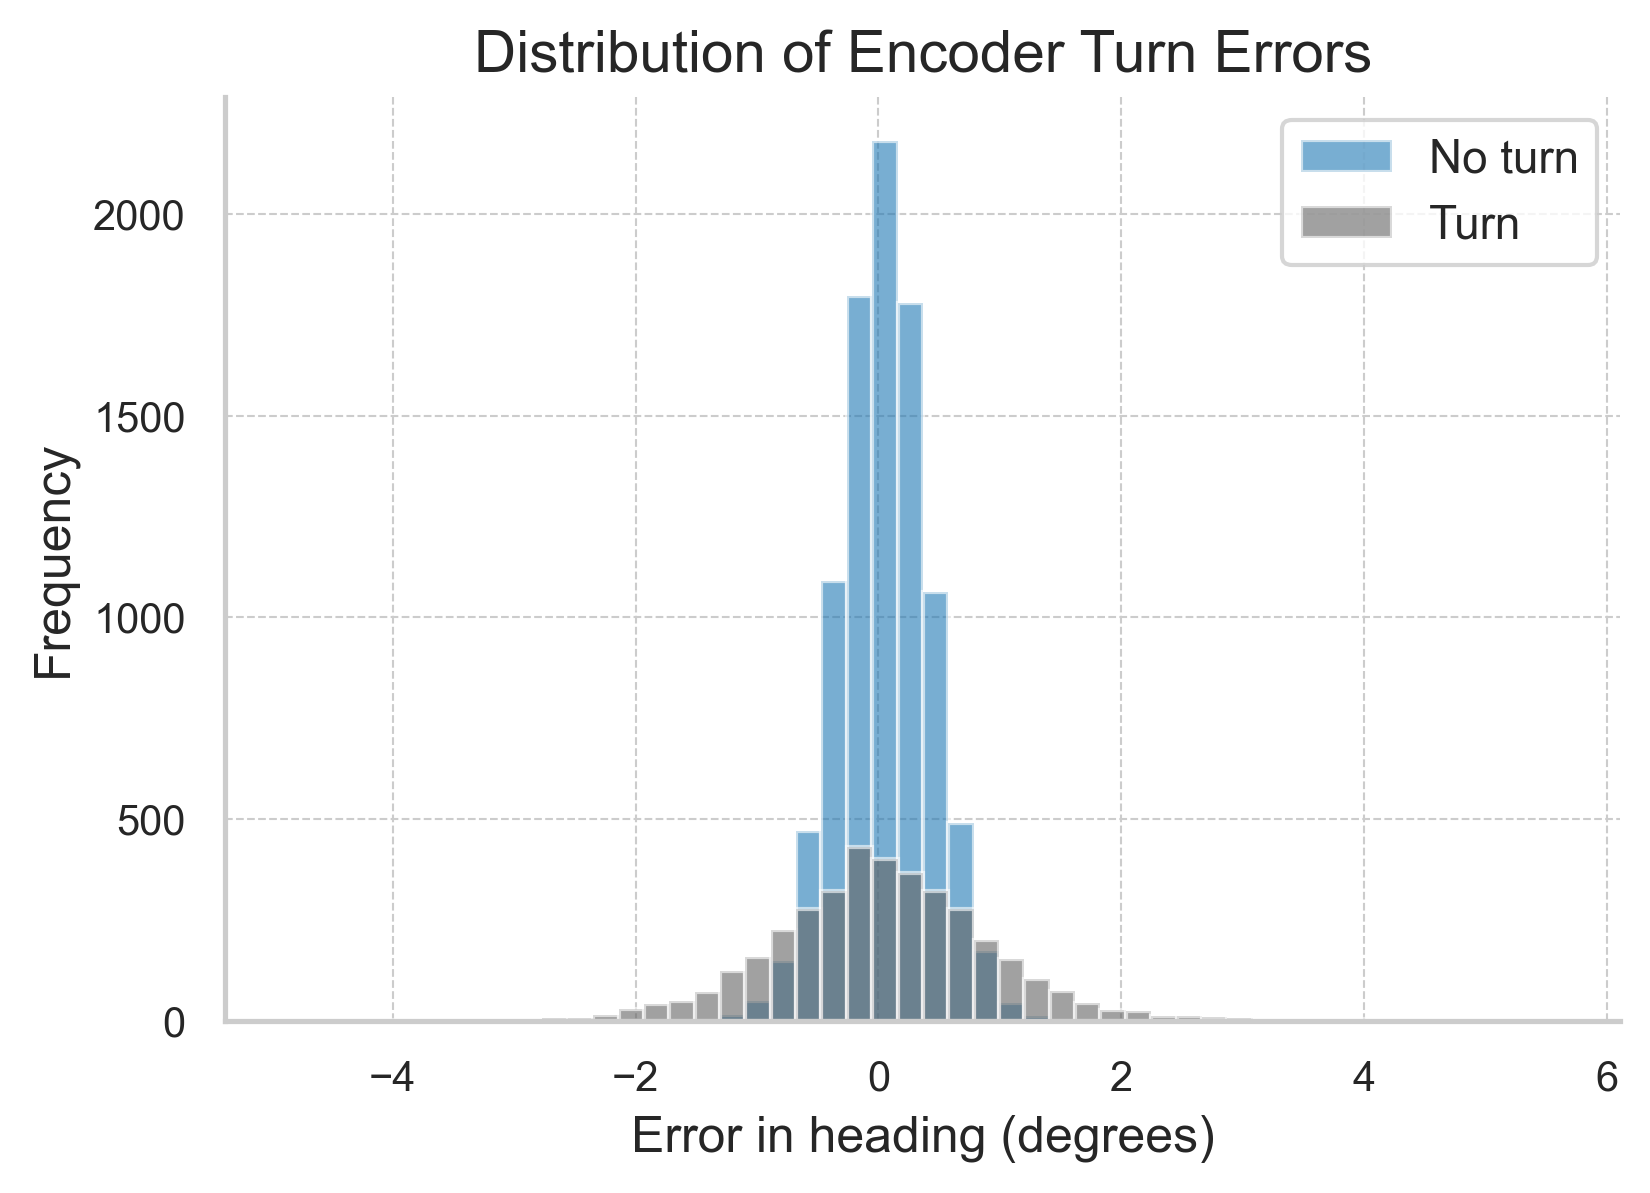

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Color palette matching paper aesthetic

colors = {
    "Turn": "#636363",     # dark gray
    "No turn": "#1f78b4"   # accent blue
}

# Styling
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "savefig.bbox": "tight"
})

# Data
turn_err = ep.filter_outliers(turn_df['encoder_heading_change_err'], threshold=8)
move_err = ep.filter_outliers(move_df['encoder_heading_change_err'], threshold=8)

# Compute shared bins based on combined range
all_err = np.concatenate([turn_err, move_err])
num_bins = 50
bin_edges = np.linspace(all_err.min(), all_err.max(), num_bins + 1)

# Plot
plt.figure(figsize=(6, 4))
plt.hist(move_err, bins=bin_edges, density=False, alpha=0.6, label='No turn',
         facecolor=colors['No turn'], rwidth=1.0)
plt.hist(turn_err, bins=bin_edges, density=False, alpha=0.6, label='Turn',
         facecolor=colors['Turn'], rwidth=1.0)


plt.title("Distribution of Encoder Turn Errors")
plt.xlabel("Error in heading (degrees)")
plt.ylabel("Frequency")
plt.legend()
sns.despine()
plt.grid(True, linestyle='--', linewidth=0.5)

# Save
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_turn_err.png')
plt.show()


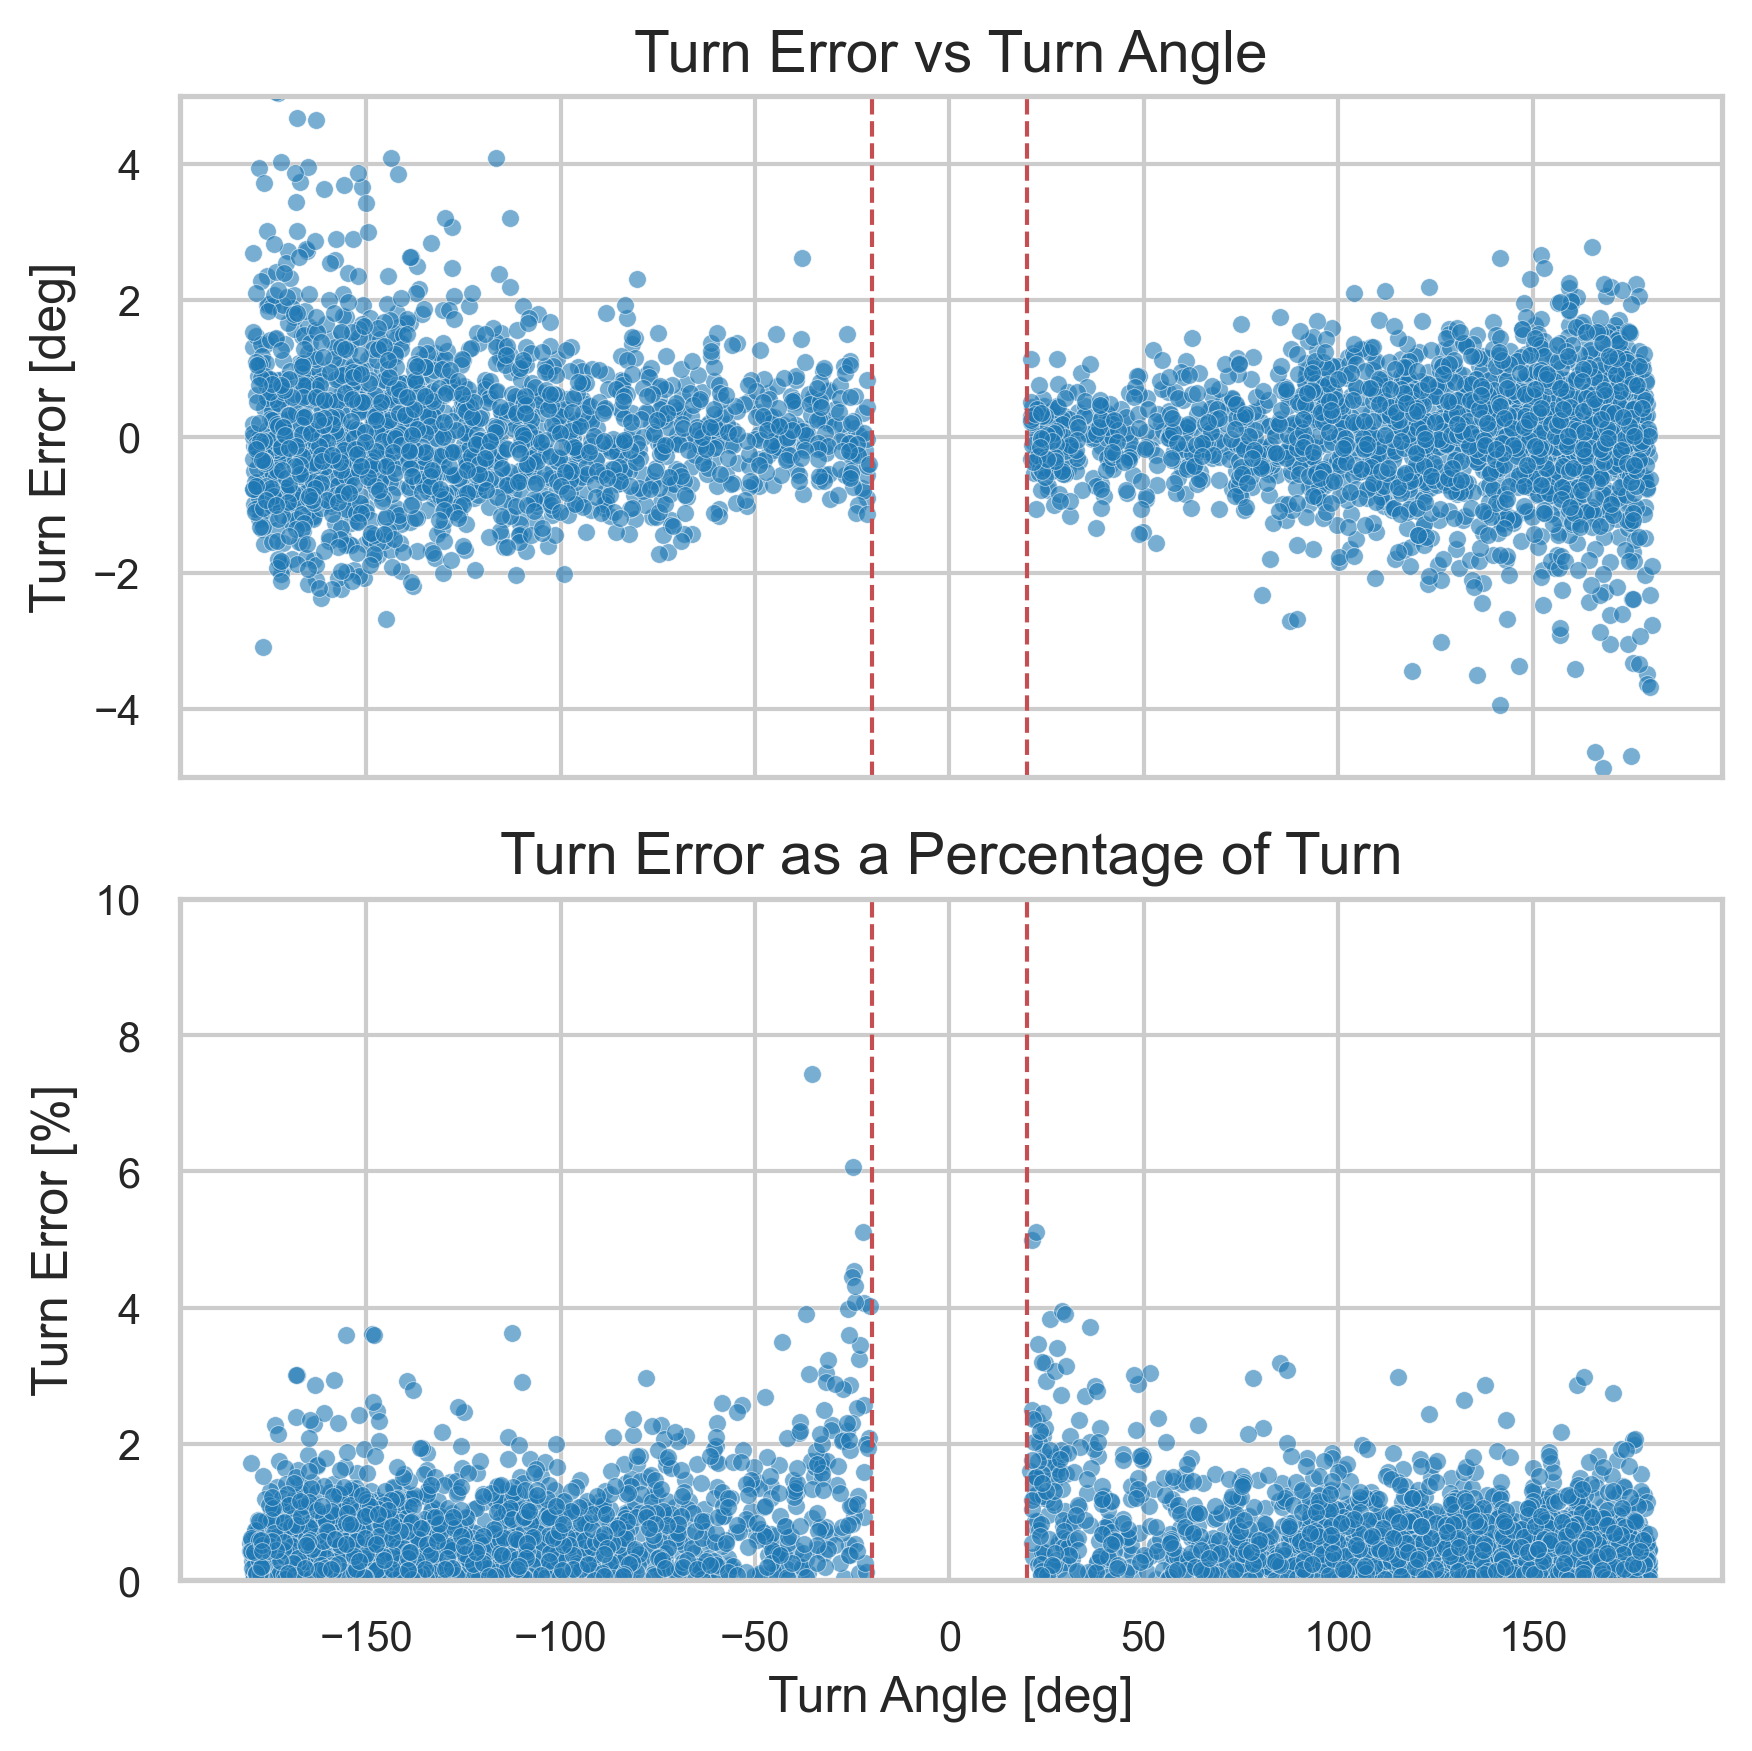

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply consistent global style
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "savefig.bbox": "tight"
})

# Compute percent error
percent_error = (
    turn_df['encoder_heading_change_err'].abs() /
    turn_df['vive_heading_change'].abs()
) * 100

# Set up figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# First plot: absolute turn error vs angle
ax1.scatter(
    turn_df['encoder_heading_change'],
    turn_df['encoder_heading_change_err'],
    s=18,
    c="#1f78b4",
    alpha=0.6,
    edgecolors='white',
    linewidth=0.2
)
ax1.axvline(-20, c='r', linestyle='--', linewidth=1)
ax1.axvline(20, c='r', linestyle='--', linewidth=1)
ax1.set_title('Turn Error vs Turn Angle')
ax1.set_ylabel('Turn Error [deg]')
ax1.set_ylim(-5, 5)
ax1.grid(True)

# Second plot: percent error vs angle
ax2.scatter(
    turn_df['vive_heading_change'],
    percent_error,
    s=18,
    c="#1f78b4",
    alpha=0.6,
    edgecolors='white',
    linewidth=0.2
)
ax2.axvline(-20, c='r', linestyle='--', linewidth=1)
ax2.axvline(20, c='r', linestyle='--', linewidth=1)
ax2.set_title('Turn Error as a Percentage of Turn')
ax2.set_xlabel('Turn Angle [deg]')
ax2.set_ylabel('Turn Error [%]')
ax2.set_ylim(0, 10)
ax2.grid(True)

# Layout and save
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_turn_err_vs_turn_angle.png')
plt.show()


In [ ]:
turn_df['enc_per_deg'] = (turn_df['encoder_heading_change_step']/turn_df['vive_heading_change'])

Text(0.5, 1.0, 'Determining the how many encoder counts per degree rotation')

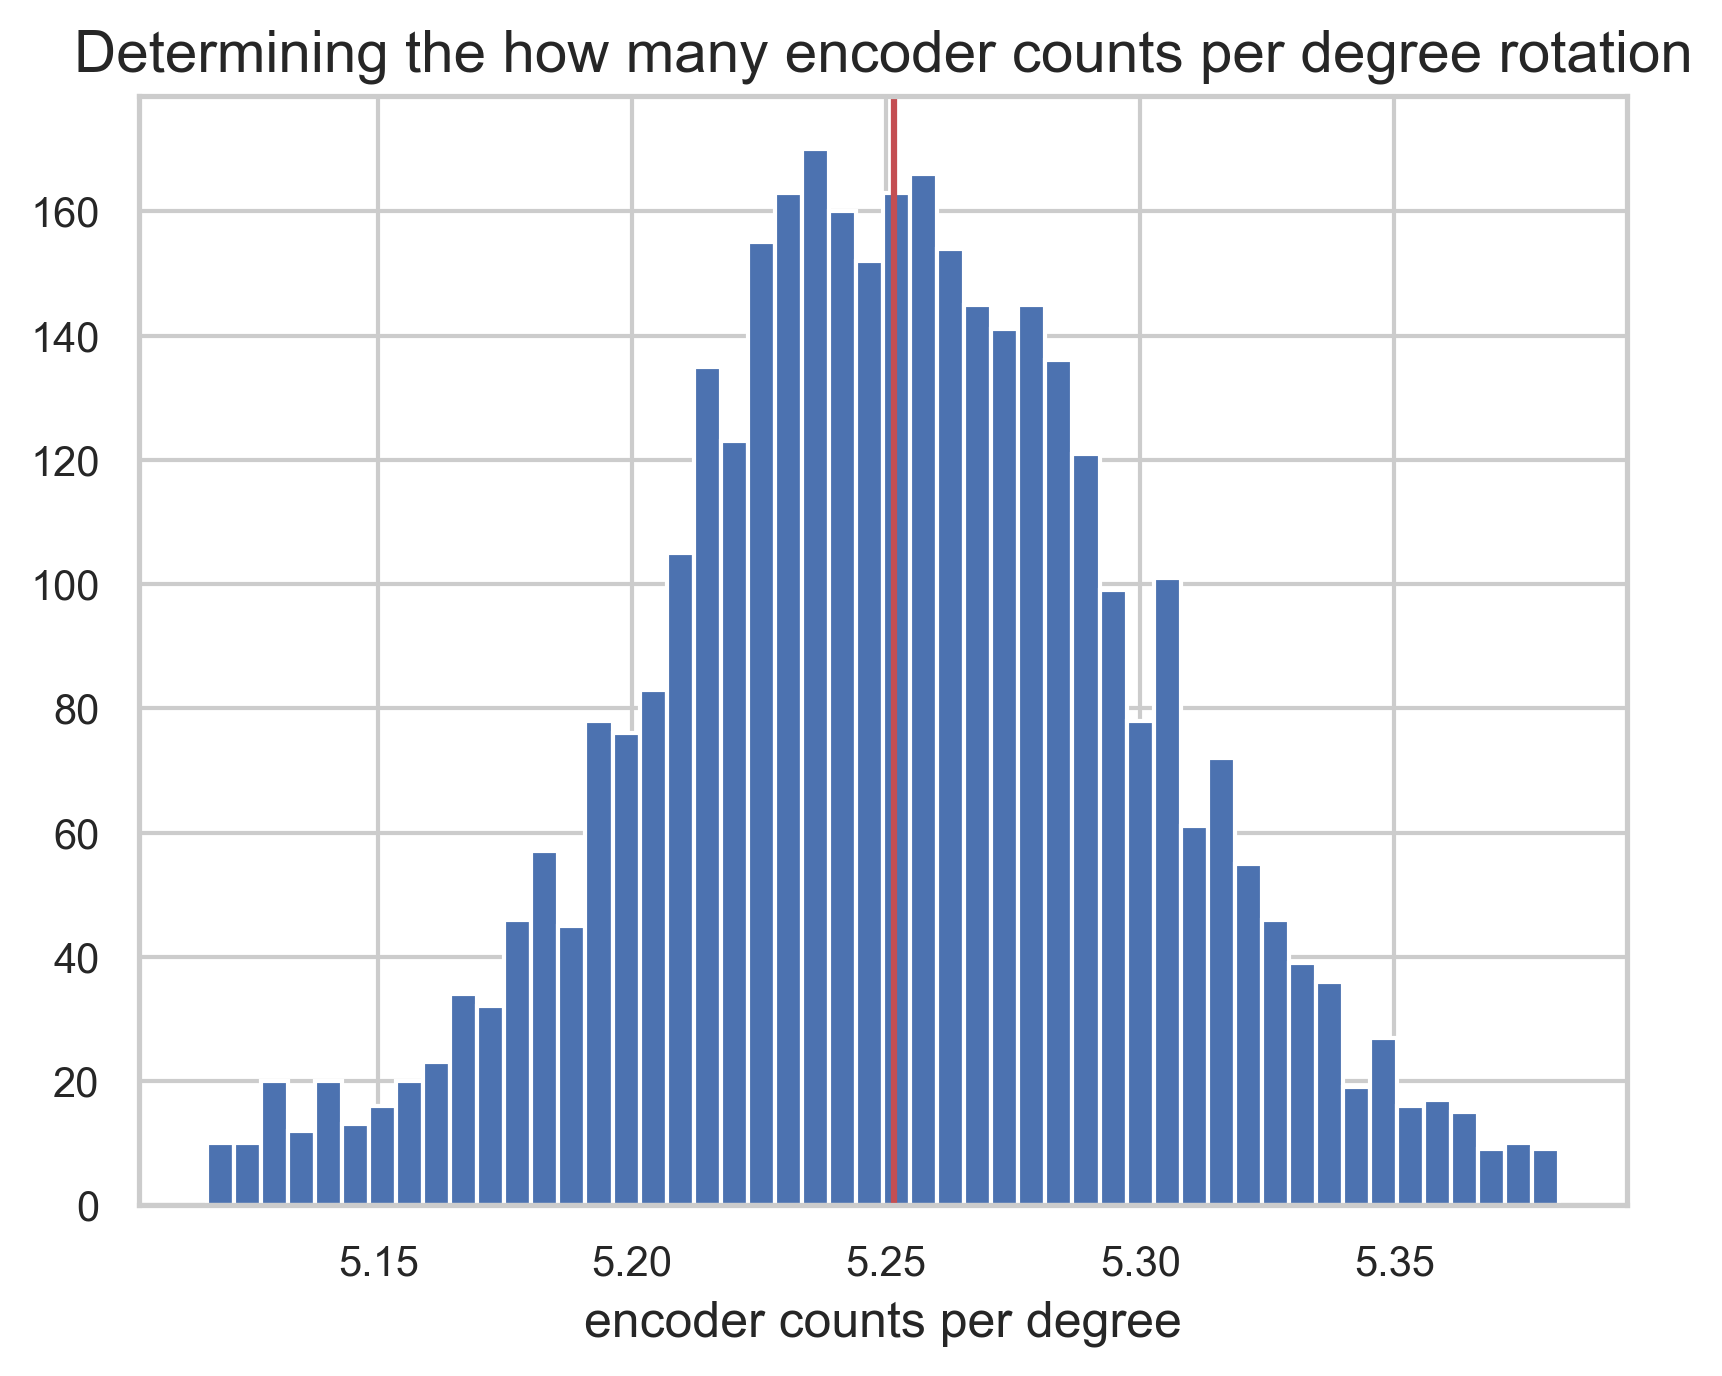

In [ ]:
_ = plt.hist(ep.filter_outliers(turn_df['enc_per_deg']), bins = 50)
plt.axvline(ep.filter_outliers(turn_df['enc_per_deg']).mean(),c = 'r')
ep.filter_outliers(turn_df['enc_per_deg']).mean()
plt.xlabel('encoder counts per degree')
plt.title('Determining the how many encoder counts per degree rotation')

# Finding error distribution

In [ ]:
def calc_pos_err(df):
    x = df['x_hist']
    y = df['y_hist']
    ex = df['encoder_x_hist']
    ey = df['encoder_y_hist']
    return np.sqrt(np.square(x - ex) + np.square(y - ey))
def calc_heading_err(df):
    heading = df['heading_hist']
    eheading = df['encoder_heading_hist']
    return np.array([abs(c.normalize_angle(a)) for a in (heading - eheading)])

def calc_vlp_pos_err_test(df):
    x = df['x_hist']
    y = df['y_hist']
    ex = df['vlp_x_hist_test']
    ey = df['vlp_y_hist_test']
    return np.sqrt(np.square(x - ex) + np.square(y - ey))

def calc_vlp_pos_err(df):
    x = df['x_hist']
    y = df['y_hist']
    ex = df['vlp_x_hist']
    ey = df['vlp_y_hist']
    return np.sqrt(np.square(x - ex) + np.square(y - ey))
def calc_vlp_heading_err(df):
    heading = df['heading_hist']
    eheading = df['vlp_heading_hist']
    return np.array([abs(c.normalize_angle(a)) for a in (heading - eheading)])

In [ ]:
color_scheme = {
    'real': '#000000',   # black
    'rnn': '#1f77b4',    # blue
    'ekf':'#2ca02c',    # green
    'vlp':  '#ff7f0e',    # orange
    'encoder': '#7f7f7f' # grey
}

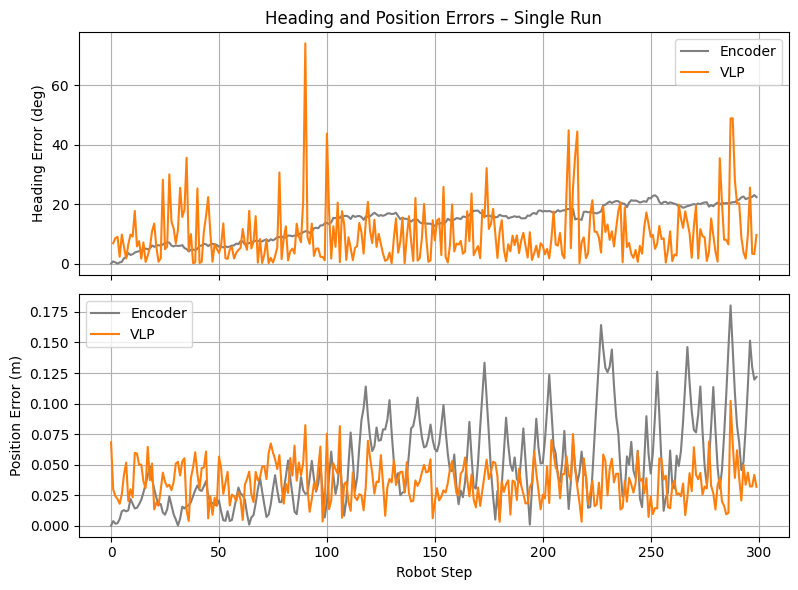

In [ ]:
import matplotlib.pyplot as plt

start_index = 0
end_index = start_index + 300

df = df_lst[9]

reset_df = df.iloc[start_index:end_index].copy().reset_index()
reset_df = ep.calc_encoder_heading_hist(reset_df)
reset_df = ep.calc_encoder_xy_hist(reset_df)

# Compute errors
head_err = calc_heading_err(reset_df)
vlp_head_err = calc_vlp_heading_err(reset_df)
pos_err = calc_pos_err(reset_df)
vlp_pos_err = calc_vlp_pos_err(reset_df)

x = range(len(head_err))

encoder_color = color_scheme['encoder']
vlp_color = color_scheme['vlp']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# --- Heading Error Plot ---
ax1.plot(x, head_err, label='Encoder', color=encoder_color)
ax1.plot(x, vlp_head_err, label='VLP', color=vlp_color)
ax1.set_ylabel('Heading Error (deg)')
ax1.set_title('Heading and Position Errors – Single Run')
ax1.grid(True)
ax1.legend()

# --- Position Error Plot ---
ax2.plot(x, pos_err, label='Encoder', color=encoder_color)
ax2.plot(x, vlp_pos_err, label='VLP', color=vlp_color)
ax2.set_xlabel('Robot Step')
ax2.set_ylabel('Position Error (m)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_err_run_combined.png', dpi=300)


### Run stats over all dataframe

In [ ]:
[len(df) for df in df_lst]

[1685, 1727, 1522, 1742, 1060, 1498, 1159, 1757, 682, 354]

In [ ]:
df = df_lst[2]

In [ ]:
win_len = 300
step = 100

pos_errs = []
vlp_pos_errs = []
ekf_pos_errs = []

head_errs = []
vlp_heading_errs = []
ekf_heading_errs = []
for df in df_lst:

    for i in range(0, len(df) - win_len, step):
        reset_df = df.iloc[i:i+win_len].copy().reset_index()
        reset_df = ep.calc_encoder_heading_hist(reset_df)
        reset_df = ep.calc_encoder_xy_hist(reset_df)
        pos_err = calc_pos_err(reset_df)
        head_err = calc_heading_err(reset_df)
        pos_errs.append(pos_err)
        head_errs.append(head_err)
        vlp_pos_errs.append(calc_vlp_pos_err(reset_df))
        # ekf_pos_errs.append(reset_df['ekf_loc_errs'])
        vlp_heading_errs.append(calc_vlp_heading_err(reset_df))
        # ekf_heading_errs.append(reset_df['ekf_ang_errs']*180/np.pi)

### Heading stats

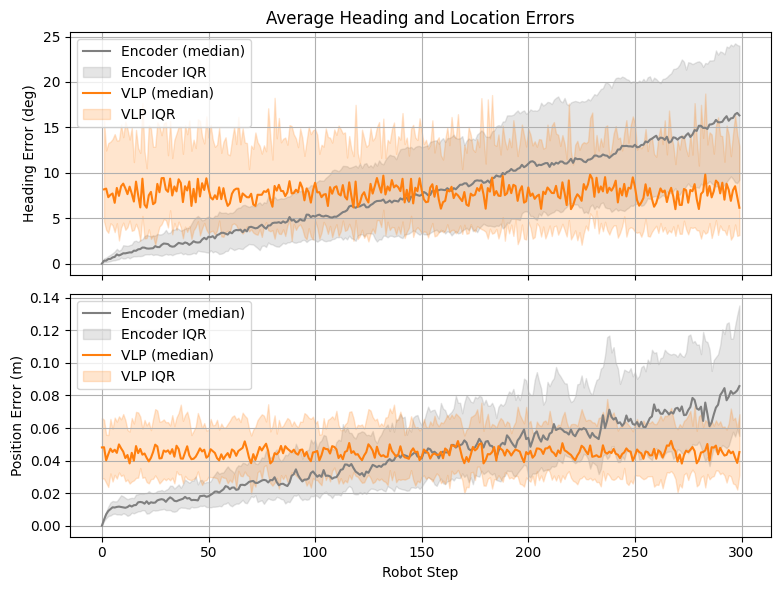

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your colors
encoder_color = color_scheme['encoder']
vlp_color = color_scheme['vlp']

# Precompute statistics
med_heading_err = np.median(np.array(head_errs), axis=0)
q1_heading_err = np.quantile(np.array(head_errs), 0.25, axis=0)
q3_heading_err = np.quantile(np.array(head_errs), 0.75, axis=0)

med_vlp_heading_err = np.median(np.array(vlp_heading_errs), axis=0)
q1_vlp_heading_err = np.quantile(np.array(vlp_heading_errs), 0.25, axis=0)
q3_vlp_heading_err = np.quantile(np.array(vlp_heading_errs), 0.75, axis=0)

med_pos_err = np.median(np.array(pos_errs), axis=0)
q1_pos_err = np.quantile(np.array(pos_errs), 0.25, axis=0)
q3_pos_err = np.quantile(np.array(pos_errs), 0.75, axis=0)

med_vlp_pos_err = np.median(np.array(vlp_pos_errs), axis=0)
q1_vlp_pos_err = np.quantile(np.array(vlp_pos_errs), 0.25, axis=0)
q3_vlp_pos_err = np.quantile(np.array(vlp_pos_errs), 0.75, axis=0)

x = range(len(med_pos_err))

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# --- Heading Error Plot ---
ax1.plot(med_heading_err, label='Encoder (median)', color=encoder_color)
ax1.fill_between(x, q1_heading_err, q3_heading_err, color=encoder_color, alpha=0.2, label='Encoder IQR')

ax1.plot(med_vlp_heading_err, label='VLP (median)', color=vlp_color)
ax1.fill_between(x, q1_vlp_heading_err, q3_vlp_heading_err, color=vlp_color, alpha=0.2, label='VLP IQR')

ax1.set_ylabel('Heading Error (deg)')
ax1.set_title('Average Heading and Location Errors')
ax1.grid(True)
ax1.legend()

# --- Position Error Plot ---
ax2.plot(med_pos_err, label='Encoder (median)', color=encoder_color)
ax2.fill_between(x, q1_pos_err, q3_pos_err, color=encoder_color, alpha=0.2, label='Encoder IQR')

ax2.plot(med_vlp_pos_err, label='VLP (median)', color=vlp_color)
ax2.fill_between(x, q1_vlp_pos_err, q3_vlp_pos_err, color=vlp_color, alpha=0.2, label='VLP IQR')

ax2.set_xlabel('Robot Step')
ax2.set_ylabel('Position Error (m)')
ax2.grid(True)
ax2.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'methodology-robot_nav_combined_errs.png', dpi=300)
